In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings(action="ignore")

## Data Load and Visualizations

In [3]:
df = pd.read_csv(os.path.join("data", "mnist_train.csv"))  # Read the training data
print(df.shape)  # Shape of the data
df.head()  # First few rows of the data

(60000, 785)


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_test = pd.read_csv(os.path.join("data", "mnist_test.csv"))  # Read the test data
print(df_test.shape)  # Shape of the test data
df_test.head()  # Show the first few rows of the test data

(10000, 785)


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


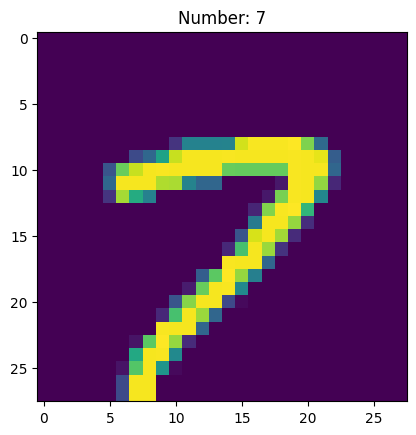

In [5]:
idx = 123  # Index of the sample to visualize
label = df.iloc[idx, 0]  # Get the label of the selected sample
sample = df.iloc[idx, 1:]  # Get the pixel values of the selected sample
sample = np.reshape(sample, (28, 28))  # Reshape the flat pixel values to 2D image

plt.title(f"Number: {label}")  # Set the title of the plot
plt.imshow(sample); # Plot the image

In [7]:
def sample_as_img(sample): # Function to convert a sample to an image
    label = sample[0]  # Get the label of the sample
    img = np.reshape(sample[1:], (28, 28))  # Reshape the pixel values to 2D image
    return img, label

In [8]:
def plot_samples(df, num_samples=10, variants=5):  # Function to plot multiple samples
    fix, axes = plt.subplots(ncols=10, nrows=5, figsize=(20, 10)) # Create a grid of 10 columns and 5 rows for plotting
    for i in range(num_samples):
        for j in range(variants):
            sample = df[df["label"] == i].iloc[j]  # Choose the first sample for each digit
            img, label = sample_as_img(sample)  # Get the image and label for the current sample
            ax = axes[j, i]  # Choose the current plot from the grid
            ax.imshow(img)  # Visualize the image
            ax.set_title(label)  # Set the plot title with the label (digit)
            # Hide the X and Y axis ticks
            ax.xaxis.set_tick_params(labelbottom=False)
            ax.yaxis.set_tick_params(labelleft=False)
            # Hide the X and Y axis labels
            ax.set_xticks([])
            ax.set_yticks([])
    plt.tight_layout()  # Automatically adjust the padding between subplots
    return plt.show()    

#### TODO: Data Check

Analyze the data by visualizing the distribution of classes (target) and examples of the classes.

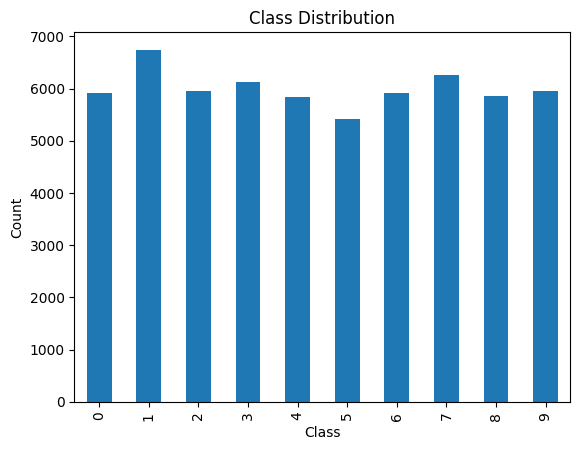

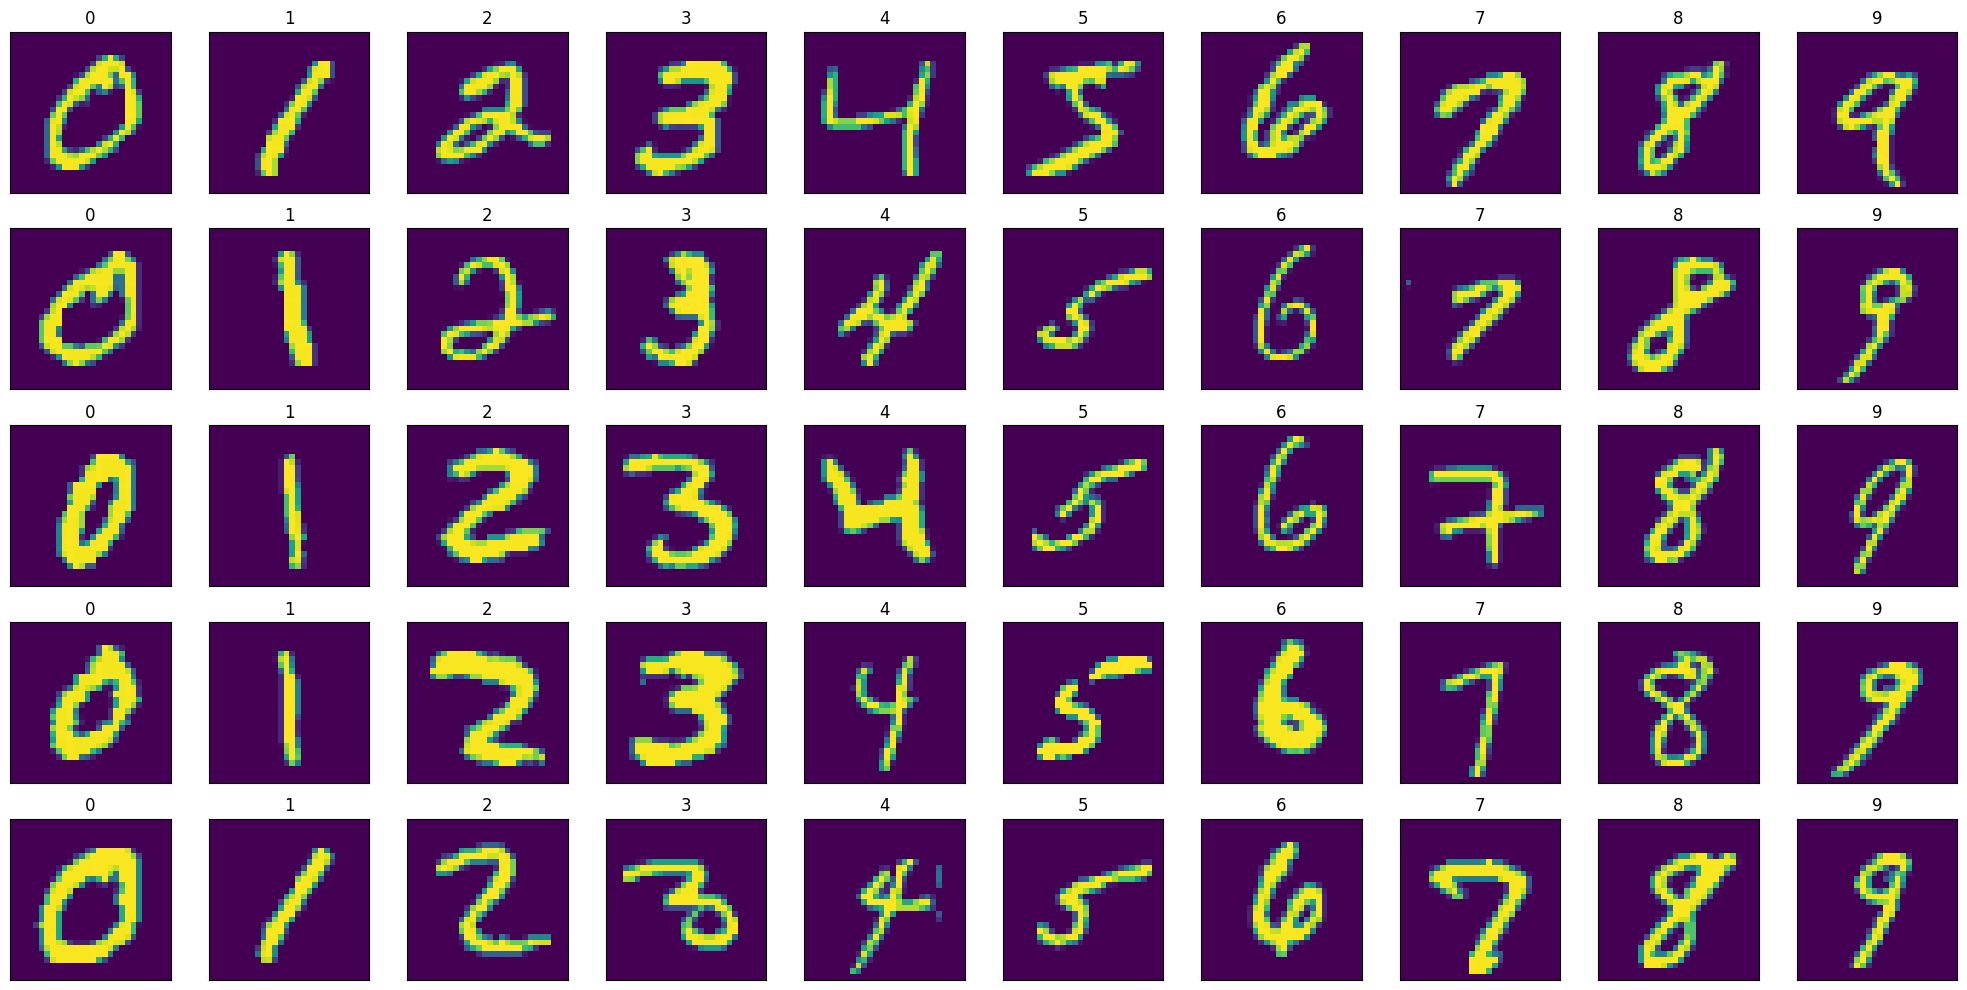

In [9]:
# Visualize the class distribution
df["label"].value_counts().sort_index().plot(kind="bar", title="Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Visualize the class examples
plot_samples(df)

## Modeling & Evaluation

#### TO DO

Based on the data distribution, choose the metric you will optimize (accuracy, precision, recall, F_1) and explain why you made this choice.

Analysis of the Metrics:
Accuracy:

Accuracy is consistently high (around 92%-93%) across all folds.
Accuracy might not be the best choice if the data distribution is imbalanced, as it doesn't distinguish between false positives and false negatives.

Precision:

Precision measures how many of the positive predictions are actually correct. It’s consistently high (around 0.86 to 0.97 per class).
Precision is important if false positives are costly (e.g., in fraud detection or medical diagnoses where unnecessary treatments are harmful).

Recall:

Recall measures how many actual positives are correctly identified. It's also consistently high (around 0.85 to 0.98 per class).
Recall is crucial if false negatives are costly (e.g., in detecting diseases where missing a case could be fatal).

F1-Score:

The F1-score balances precision and recall, making it useful when both false positives and false negatives are important.
It’s consistently high across all classes (around 0.86 to 0.96), indicating that the model is well-balanced in most cases.

Macro and Weighted Averages:

Macro average considers all classes equally, regardless of their support.

Weighted average accounts for class imbalance by weighting metrics according to class support.

Decision guidance:

Optimize Precision: If the cost of false positives is high (e.g., predicting something as positive when it's not), prioritize precision.

Optimize Recall: If the cost of false negatives is high (e.g., missing a positive case), prioritize recall.

Optimize F1-Score: If you need a balance between precision and recall or have no clear preference between false positives and false negatives, prioritize the F1-score.

My Recommendation:
From the data distribution and consistently high performance across metrics, F1-score would be a good choice as it balances precision and recall effectively.

In [10]:
# Split the data into features and labels
X = df.iloc[:, 1:].values / 255.0  # Convert the pixel values to [0,1]
y = df.iloc[:, 0].values  # Get the labels

X_test = df_test.iloc[:, 1:].values / 255.0  # Convert the pixel values to [0,1] for the test data
y_test = df_test.iloc[:, 0].values  # Get the labels for the test data

In [11]:
n_folds = 5  # Number of folds for cross-validation

for fold_idx, (train_idxs, valid_idxs) in enumerate(KFold(n_splits=n_folds).split(X)):
    x_train, y_train = X[train_idxs], y[train_idxs]  # Get the training set
    x_valid, y_valid = X[valid_idxs], y[valid_idxs]  # Get the validation set
    model = LogisticRegression(penalty=None)  # Initialize the model
    model.fit(x_train, y_train)  # Train the model
    y_pred = model.predict(x_valid)  # Predict the validation set
    report = classification_report(y_valid, y_pred)  # Generate the classification report
    print(f"\n[Fold {fold_idx+1}/{n_folds}]")  # Print the fold index
    print(report)  # Print the classification report


[Fold 1/5]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1206
           1       0.95      0.97      0.96      1351
           2       0.91      0.90      0.91      1176
           3       0.89      0.89      0.89      1228
           4       0.92      0.94      0.93      1184
           5       0.91      0.88      0.89      1048
           6       0.94      0.96      0.95      1208
           7       0.95      0.92      0.94      1279
           8       0.89      0.85      0.87      1127
           9       0.90      0.92      0.91      1193

    accuracy                           0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000


[Fold 2/5]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1175
           1       0.96      0.97      0.96      1381
           2       0.90      0.88      0.89      1171


In [12]:
model = LogisticRegression(penalty=None)  # Initialize the model
model.fit(X, y)  # Train the model on the full training data

print(classification_report(y_test, model.predict(X_test)))  # Generate the classification report for the test data

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.91      0.91      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.90      0.88      0.89       892
           6       0.94      0.95      0.95       958
           7       0.94      0.92      0.93      1028
           8       0.87      0.88      0.88       974
           9       0.91      0.92      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



#### TO DO:

Find the model that would work best on the test data. Try different values for the `penalty` parameter: {‘l1’, ‘l2’, ‘elasticnet’, None}).
Provide the metrics of the models on the test data that you evaluated.

In [14]:
penalties = ['l1', 'l2', 'elasticnet', None]  # Define the penalties to try

for penalty in penalties:  # Iterate over the penalties
    if penalty == 'elasticnet':
        # Elasticnet requires an l1_ratio parameter
        l1_ratio = 0.5  # Set the l1_ratio to 0.5
        model = LogisticRegression(penalty=penalty, solver='saga', l1_ratio=l1_ratio, max_iter=10000)
    else:
        model = LogisticRegression(penalty=penalty, solver='saga', max_iter=10000)  # 'saga' works with l1, l2, and elasticnet
    model.fit(X_test, y_test)  # Train the model
    report = classification_report(y_test, model.predict(X_test))  # Generate the classification report
    print(f"\n[Penalty: {penalty}]")  # Print the penalty
    print(report)  # Print the classification report


[Penalty: l1]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.96      0.95      0.95      1032
           3       0.96      0.95      0.95      1010
           4       0.96      0.97      0.97       982
           5       0.94      0.94      0.94       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.96      1028
           8       0.95      0.95      0.95       974
           9       0.94      0.94      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000


[Penalty: l2]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97     